# Week 2 Project 
 Jiwei Xia

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t, shapiro
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# upload documents, run this only when using Google Colab
from google.colab import files
uploaded1 = files.upload()
uploaded2 = files.upload()

Saving problem1.csv to problem1.csv


Saving problem2.csv to problem2.csv


## Problem 1

QUESTION: 

The conditional expectation of the multivariate normal should be equal to the expected value from an OLS regression.

Use the data in problem1.csv to prove your answer empirically.

SOLUTION: 

To solve this question with "problem1.csv" datasets with two variables x and y, we will need to do following steps.

1.1 Given that $$\overline{μ} = μ_{1} + Σ_{12}Σ_{22}^{-1}(α - μ_{2})$$

As we assume x,y variables in our datasets are independent, we calculate their mean and variance and apply it to get the conditional distribution.

1.2 Using the sklearn packages in Python, we can fit the variable x with Ordinary Least Square.

1.3 Compare the result between step1 and step2

In [29]:
# read the data and reshape it in a column
my_data1 = np.genfromtxt('problem1.csv', delimiter=',')
my_data1 = np.delete(my_data1, 0, 0)
x1 = my_data1[:, 0].reshape(-1, 1)
y1 = my_data1[:, 1].reshape(-1, 1)

1.1 Calculate conditional mean from equation

In [30]:
# calculate the mean
mean_x = np.mean(x1)
mean_y = np.mean(y1)
# calculate the covariance matrix
cov = np.cov(x1.T, y1.T, bias=False)
cov_xy = cov[0][1]
var_x = cov[0][0]
var_y = cov[1][1]
# calculate the conditional mean
conditional_mean = mean_y + cov_xy / var_x * (x1 - mean_x)

1.2 Fit the data with OLS and calculate mean.

In [31]:
reg1 = LinearRegression()
reg1.fit(x1, y1)
y_pred1 = reg1.predict(x1)

1.3 Plot the results and compare.

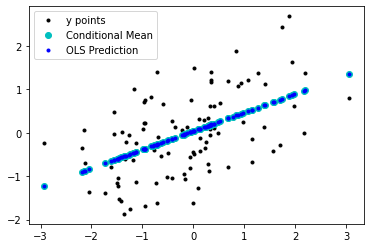

In [32]:
plt.figure()
plt.plot(x1, y1, 'k.', label='y points')
plt.plot(x1, conditional_mean, 'co', label='Conditional Mean')
plt.plot(x1, y_pred1, 'b.', label='OLS Prediction')
plt.legend()
plt.show()

ANSWER: 

With the plot, we saw the results from Conditional Mean and OLS Prediction are completely overlapped, which empirically indicates that these two are identical.

EXTRA CREDIT: 

Prove mathematically that the expected value from both equations are the same.

ANSWER: The optimal estimator for OLS is that: 
$$\hat{\beta} = (X'X)^{-1}X'Y$$
We can expand the expression and have: 
$$\hat{\beta_i} = \frac{cov(x_i, y)}{\sigma_x^2}$$
So for $\hat{\beta_1}$,  the expression is: 
$$\hat{\beta_1} = \frac{\sigma_{xy}}{\sigma_x^2}$$
For each estimated y, we have: 
$$\hat{y} = \hat{\beta_0} + \hat{\beta_1}x$$
For the expected value, we have: 
$$\overline{y} = \hat{\beta_0} + \hat{\beta_1}\overline{x}$$
We can combine these 2 equations as:
$$\hat{y} - \overline{y} = \hat{\beta_0} + \hat{\beta_1}x - (\hat{\beta_0} + \hat{\beta_1}\overline{x})$$
So that:
$$\hat{y} = \overline{y} + \hat{\beta_1}(x - \overline{x})$$
We can substitute the value of $\hat{\beta_1}$ from above and get:
$$\hat{y} = \overline{y} + \frac{\sigma_{xy}}{\sigma_x^2}(x - \overline{x})$$
While the equation for y conditional expectation is:
$$\overline{μ} = μ_{1} + Σ_{12}Σ_{22}^{-1}(α - μ_{2})$$
It's clear that these 2 equations are the same, meaning that the expected value from from both equations are the same.

## Problem 2

QUESTION: 

2.1 Fit the data in problem2.csv using OLS and calculate the error vector. Look at its distribution. How well does it fit the assumption of normally distributed errors? 

2.2 Fit the data using MLE given the assumption of normality. Then fit the assumption of a T distribution of the errors. What is the best fit?

2.3 What are the fitted parameters of each and how do they compare? What does this tell us about the breaking the normality assumption in regards to the expected values in this case?

SOLUTION: In the following steps, we will use different models to fit the data and plot the result to answer the questions.

In [33]:
# read the variable and reshape it in a column
my_data2 = np.genfromtxt('problem2.csv', delimiter=',')
my_data2 = np.delete(my_data2, 0, 0)
x2 = my_data2[:, 0].reshape(-1, 1)
y2 = my_data2[:, 1].reshape(-1, 1)

2.1 Fit the data using OLS and calculate error vector.

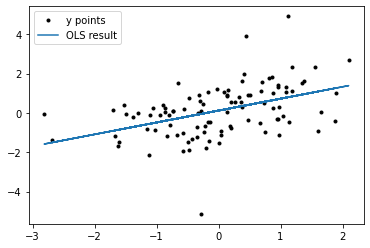

In [34]:
# use the sklearn package to fit data with OLS and plot the result
reg2 = LinearRegression()
reg2.fit(x2, y2)
y_pred2 = reg2.predict(x2)

plt.figure()
plt.plot(x2, y2, 'k.', label = 'y points')
plt.plot(x2, y_pred2, label = 'OLS result')
plt.legend()
plt.show()

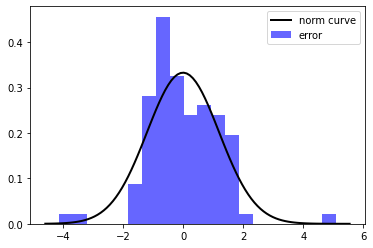

In [35]:
# calculate the error vector and plot the result
error = (y_pred2 - y2)
# calculate the mean and std to draw a normal distribution line
mu, std = norm.fit(error)

plt.figure()
plt.hist(error, bins=20, density=True, alpha=0.6, color='b', label = 'error')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label = 'norm curve')
plt.legend()
plt.show()

In [36]:
# we can also use Shapiro-Wilks test to determine if the error follows normal distribution.
test_stat, p = shapiro(error)
print(p)

0.0001538837095722556


ANSWER: 

As it shown on the graph, the error vector is basically following the normal distribution but not very well. So we tried using the Shapiro-Wilks test and found that the p value is around 0.00015, which is significantly smaller than the commonly applied alpha-level 0.05. As a conclusion, the null hypothesis can be rejected, meaning the errors are not normally distributed.

2.2.1 Fit the data using MLE with normal distribution/ T distribution assumption.

In [37]:
class MLE:
  def __init__(self, x, y):
    self.x = x
    self.y = y

  # calculate the negative log likelihood as cost function
  # assume normal distribution
  def normal_nll(self, params):
    k = params[0]   
    b = params[1]
    sigma = params[2]
    error_dist = norm(0, sigma)
    error = self.y - b - k * self.x
    nll = -np.log(error_dist.pdf(error)).sum()
    return nll

  # assume t distribution
  def t_nll(self, params):
    k = params[0]   
    b = params[1]
    df = params[2]
    scale = params[3]
    error_dist = t(df, scale)
    error = self.y - b - k * self.x
    nll = -np.log(error_dist.pdf(error)).sum()
    return nll

  # solve for optimal parameters
  def normal_optimize(self, init_params):
    result = minimize(self.normal_nll, init_params, method='BFGS')
    return result

  # solve for optimal parameters
  def t_optimize(self, init_params):
    result = minimize(self.t_nll, init_params, method='BFGS')
    return result

In [38]:
# initialize the class
mle_class = MLE(x2, y2)

# set initial guess and solve for optimal parameters for normal distribution
init_params = [1, 1, 1]
result_norm = mle_class.normal_optimize(init_params)
print(result_norm)

      fun: 159.9920966891626
 hess_inv: array([[ 1.53221479e-02, -1.13931717e-04, -3.25060909e-04],
       [-1.13931717e-04,  1.42416301e-02, -6.19555237e-05],
       [-3.25060909e-04, -6.19555237e-05,  7.44517289e-03]])
      jac: array([ 3.81469727e-06, -1.90734863e-06, -3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 12
     njev: 15
   status: 0
  success: True
        x: array([0.60520483, 0.11983613, 1.19839408])


In [39]:
# set initial guess and solve for optimal parameters for t distribution
init_params = [1, 1, 1, 1]
result_t = mle_class.t_optimize(init_params)
print(result_t)

      fun: 155.51528727578824
 hess_inv: array([[ 1.43080166e-02,  9.68168081e-04,  1.39672267e-02,
         9.68168081e-04],
       [ 9.68168081e-04,  5.03340512e-01, -9.68910265e-03,
        -4.96659488e-01],
       [ 1.39672267e-02, -9.68910265e-03,  7.72993598e+00,
        -9.68910265e-03],
       [ 9.68168081e-04, -4.96659488e-01, -9.68910265e-03,
         5.03340512e-01]])
      jac: array([0.00000000e+00, 1.90734863e-06, 0.00000000e+00, 1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 80
      nit: 14
     njev: 16
   status: 0
  success: True
        x: array([0.55893055, 0.0699807 , 6.75735963, 0.0699807 ])


2.2.2 Which is the best fit: Now we need to compare the goodness of fitting between normal distribution assumption and t distribution assumption. We will calculate the SSE, AIC and BIC of both cases and compare.

In [40]:
k_norm = result_norm.x[0]
b_norm = result_norm.x[1]
y_pred2_mle_norm = k_norm * x2 + b_norm

k_t = result_t.x[0]
b_t = result_t.x[1]
y_pred2_mle_t = k_t * x2 + b_t

# calculate the SSE (sum of squared errors)
SSE_norm = np.square(y_pred2_mle_norm - y2).sum()
SSE_t = np.square(y_pred2_mle_t - y2).sum()
print('SSE_normal =', SSE_norm, ', SSE_t =', SSE_t)

# calculate the AIC (akaike information criterion)
AIC_norm = 2 * len(result_norm.x) - 2 * (-result_norm.fun)
AIC_t = 2 * len(result_t.x) - 2 * (-result_t.fun)
print('AIC_normal =', AIC_norm, ', AIC_t =', AIC_t)

# calculate the BIC (bayes information criterion)
BIC_norm = len(result_norm.x) * np.log(len(y2)) - 2 * (-result_norm.fun)
BIC_t = len(result_t.x) * np.log(len(y2)) - 2 * (-result_t.fun)
print('BIC_normal =', BIC_norm, ', BIC_t =', BIC_t)

SSE_normal = 143.61484854062655 , SSE_t = 144.06627111517466
AIC_normal = 325.9841933783252 , AIC_t = 319.0305745515765
BIC_normal = 333.79970393628946 , BIC_t = 329.4512552955288


ANSWER: Given the results, we found that the one with t distribution assumption has a slightly higher SSE but a much lower AIC and BIC. Thus, we conclude that t distribution has a better fit.

2.3 What are the fitted parameters of each and how do they compare?

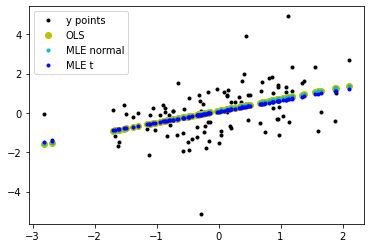

In [41]:
# Plot the OLS, MLE normal and MLE t fitting results.
plt.figure()
plt.plot(x2, y2, 'k.', label='y points')
plt.plot(x2, y_pred2, 'yo', label='OLS')
plt.plot(x2, y_pred2_mle_norm, 'c.', label='MLE normal')
plt.plot(x2, y_pred2_mle_t, 'b.', label='MLE t')
plt.legend()
plt.show()

In [42]:
# print the parameters fitted by MLE normal
print('k =', result_norm.x[0], ', b =', result_norm.x[1])

k = 0.6052048325056226 , b = 0.119836134235733


In [43]:
# print the parameters fitted by MLE t
print('k =', result_t.x[0], ', b =', result_t.x[1])

k = 0.5589305530986876 , b = 0.06998069543562838


ANSWER: We can see from the plot and the values, that the k and b parameters are similar for both cases, but not the same. This tells us that if the error doesn't follow normal distribution, then expected value of y based on MLE will become different from OLS.

## Problem 3

QUESTION:

Simulate AR(1) through AR(3) and MA(1) through MA(3) processes. Compare their ACF and PACF graphs. How do graphs help us to identify the type and order of each process.

SOLUTION:

3.1 Simulate AR(1) through AR(3) and plot their ACF & PACF graphs.

In [44]:
# set zero lag
ar0 = np.array([1])
ma0 = np.array([1])
# set a fixed random seed to ensure same result for each round
np.random.seed(12345)

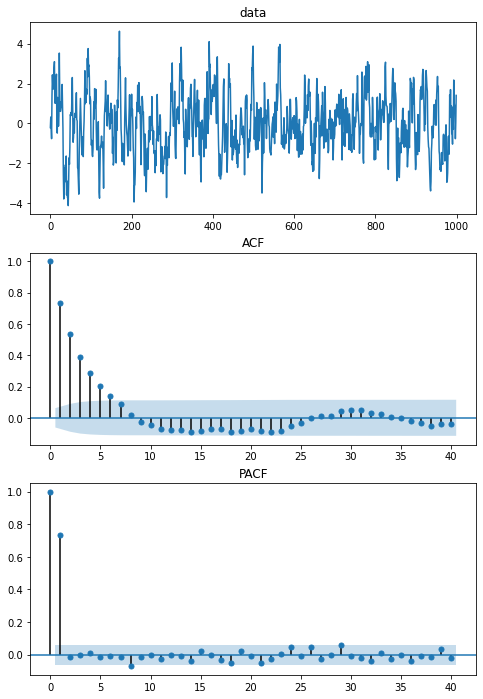

In [45]:
# AR(1)
# use similar parameters as official document
ar1 = np.array([1, -0.75])
ar1_process = ArmaProcess(ar1, ma0)
ar1_simulate = ar1_process.generate_sample(nsample=1000)
# set alpha-level for acf and pacf plots
alpha = 0.05
# set lags for acf and pacf plots
lags = 40

fig, axes = plt.subplots(3, 1, figsize=(8, 12))
axes[0].plot(ar1_simulate)
plot_acf(ar1_simulate, alpha=alpha, lags=lags, ax=axes[1])
plot_pacf(ar1_simulate, alpha=alpha, lags=lags, ax=axes[2])
axes[0].set_title('data')
axes[1].set_title('ACF')
axes[2].set_title('PACF')
plt.show()

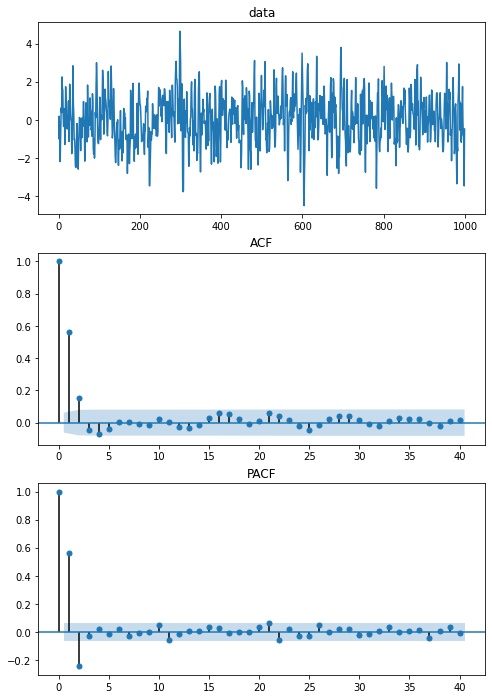

In [46]:
# AR(2)
ar2 = np.array([1, -0.75, 0.25])
ar2_process = ArmaProcess(ar2, ma0)
ar2_simulate = ar2_process.generate_sample(nsample=1000)

fig, axes = plt.subplots(3, 1, figsize=(8, 12))
axes[0].plot(ar2_simulate)
plot_acf(ar2_simulate, alpha=alpha, lags=lags, ax=axes[1])
plot_pacf(ar2_simulate, alpha=alpha, lags=lags, ax=axes[2])
axes[0].set_title('data')
axes[1].set_title('ACF')
axes[2].set_title('PACF')
plt.show()

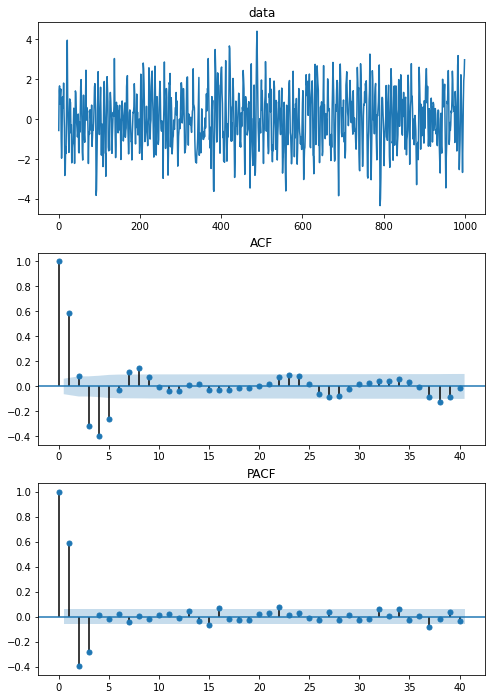

In [47]:
# AR(3)
ar3 = np.array([1, -0.75, 0.25, 0.25])
ar3_process = ArmaProcess(ar3, ma0)
ar3_simulate = ar3_process.generate_sample(nsample=1000)

fig, axes = plt.subplots(3, 1, figsize=(8, 12))
axes[0].plot(ar3_simulate)
plot_acf(ar3_simulate, alpha=alpha, lags=lags, ax=axes[1])
plot_pacf(ar3_simulate, alpha=alpha, lags=lags, ax=axes[2])
axes[0].set_title('data')
axes[1].set_title('ACF')
axes[2].set_title('PACF')
plt.show()

3.2 Simulate MA(1) through MA(3) and plot their ACF & PACF graphs.

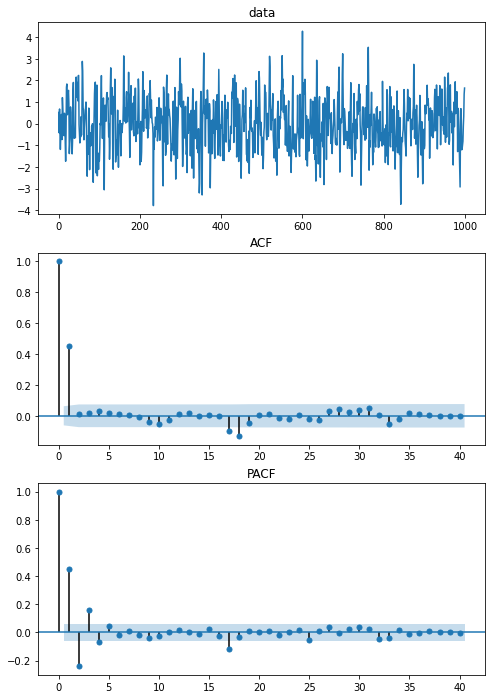

In [48]:
# MA(1)
ma1 = np.array([1, 0.65])
ma1_process = ArmaProcess(ar0, ma1)
ma1_simulate = ma1_process.generate_sample(nsample=1000)

fig, axes = plt.subplots(3, 1, figsize=(8, 12))
axes[0].plot(ma1_simulate)
plot_acf(ma1_simulate, alpha=alpha, lags=lags, ax=axes[1])
plot_pacf(ma1_simulate, alpha=alpha, lags=lags, ax=axes[2])
axes[0].set_title('data')
axes[1].set_title('ACF')
axes[2].set_title('PACF')
plt.show()

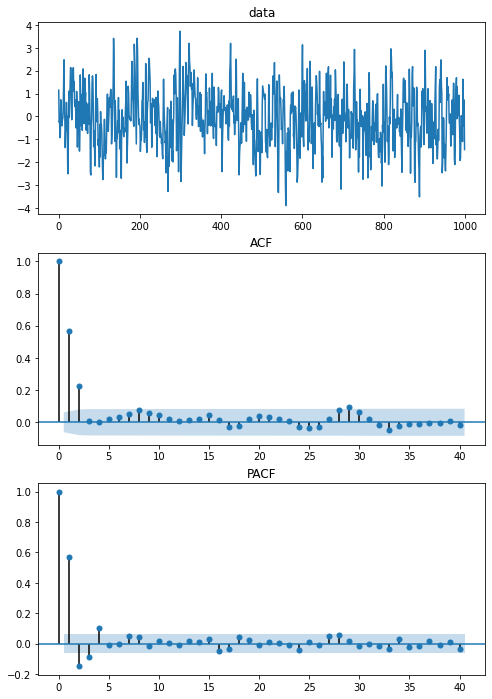

In [49]:
# MA(2)
ma2 = np.array([1, 0.65, 0.35])
ma2_process = ArmaProcess(ar0, ma2)
ma2_simulate = ma2_process.generate_sample(nsample=1000)

fig, axes = plt.subplots(3, 1, figsize=(8, 12))
axes[0].plot(ma2_simulate)
plot_acf(ma2_simulate, alpha=alpha, lags=lags, ax=axes[1])
plot_pacf(ma2_simulate, alpha=alpha, lags=lags, ax=axes[2])
axes[0].set_title('data')
axes[1].set_title('ACF')
axes[2].set_title('PACF')
plt.show()

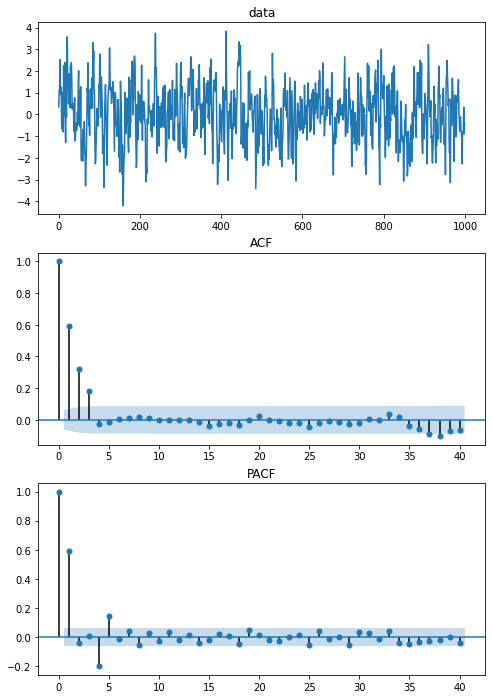

In [50]:
# MA(3)
ma3 = np.array([1, 0.65, 0.35, 0.35])
ma3_process = ArmaProcess(ar0, ma3)
ma3_simulate = ma3_process.generate_sample(nsample=1000)

fig, axes = plt.subplots(3, 1, figsize=(8, 12))
axes[0].plot(ma3_simulate)
plot_acf(ma3_simulate, alpha=alpha, lags=lags, ax=axes[1])
plot_pacf(ma3_simulate, alpha=alpha, lags=lags, ax=axes[2])
axes[0].set_title('data')
axes[1].set_title('ACF')
axes[2].set_title('PACF')
plt.show()

ANSWER:

Given the result, we will see that the ACF and PACF plots together help us differentiate the AR/MA process and their term. For instance, we expect to see that in AR process, the ACF plot will gradually decrease while the PACF has a significant drop after the n significant lags. For the MA process, two plots behave the opposite. 